## Problem definition and Model outcome

The objective is to build a deep learning model that classifies kidney CT scan images into four categories: Normal, Cyst, Tumor, and Stone. The goal is to automate the process of identifying these conditions, improving diagnostic efficiency and accuracy in medical imaging. The model utilizes transfer learning with a pre-trained EfficientNet architecture and employs techniques like data augmentation, class balancing, and hyperparameter tuning to achieve high performance.

# Getting the Dataset

In [ ]:
def download_kaggle_dataset(kaggle_data_path, is_competition=False):
  dataset_name = kaggle_data_path.split("/")[-1]

  # Install Kaggle API
  !pip install -q kaggle

  # Upload the Kaggle API key (kaggle.json)
  from google.colab import files
  files.upload()

  # Move kaggle.json to the .kaggle directory and set proper permissions
  !mkdir -p ~/.kaggle
  !mv kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  # Download the dataset or competition data
  if is_competition:
    !kaggle competitions download -c {kaggle_data_path}
  else:
    !kaggle datasets download -d {kaggle_data_path}

  # Unzip the downloaded dataset into the created folder
  !unzip -q {dataset_name}.zip -d {dataset_name}

  # Delete the zip file after unzipping
  !rm {dataset_name}.zip

In [ ]:
import glob as gb
def check_and_download_dataset(kaggle_path, colab_path):
  try:
    # Check if dataset is already available in Kaggle
    if gb.glob(pathname=kaggle_path+"*"):
      print("Dataset already available in Kaggle")
      return kaggle_path

    # Check if dataset is already downloaded in Colab
    elif gb.glob(pathname=colab_path+"*"):
      print("Dataset already downloaded in Colab")
      return colab_path

    # Raise an error if the dataset is not found
    raise FileNotFoundError

  except FileNotFoundError:
    # If running in Colab, download the dataset
    import google.colab
    print("Running in Google Colab")
    print("Downloading Kaggle dataset...")
    download_kaggle_dataset("nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone")
    return colab_path

In [ ]:
kaggle_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/"
colab_path = "/content/ct-kidney-dataset-normal-cyst-tumor-and-stone/"
MAIN_PATH = check_and_download_dataset(kaggle_path, colab_path)

Running in Google Colab


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
License(s): copyright-authors
 99% 1.51G/1.52G [00:12<00:00, 125MB/s]
100% 1.52G/1.52G [00:12<00:00, 126MB/s]


## Libraries

In [ ]:
# Data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob as gb
from tqdm.auto import tqdm

# PyTorch libraries for deep learning
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision import datasets, transforms
from PIL import Image

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Visualize and Analyze
   - Check for:
     - Image size consistency
     - Need for augmentation
     - Class imbalances

In [ ]:
# Define the path to the dataset
Images_Path="/content/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
print("Classes:", os.listdir(Images_Path))
print("Classes:", os.listdir(Images_Path))


Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [ ]:
# Function to count the number of images in each class
def count_image_df(path):
    df = pd.DataFrame(columns=["Class", "Count"])
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)  # Join the path correctly
        if os.path.isdir(folder_path):  # Ensure it is a directory
            files = gb.glob(os.path.join(folder_path, "*.jpg"))  # Correct file pattern
            df.loc[len(df.index)] = [folder, len(files)]
    return df

# Update the path with your dataset directory
Images_Path= "/content/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
# Generate counts for each class
count_image = count_image_df(Images_Path)
count_image


,Class,Count
0,Cyst,3709
1,Normal,5077
2,Stone,1377
3,Tumor,2283


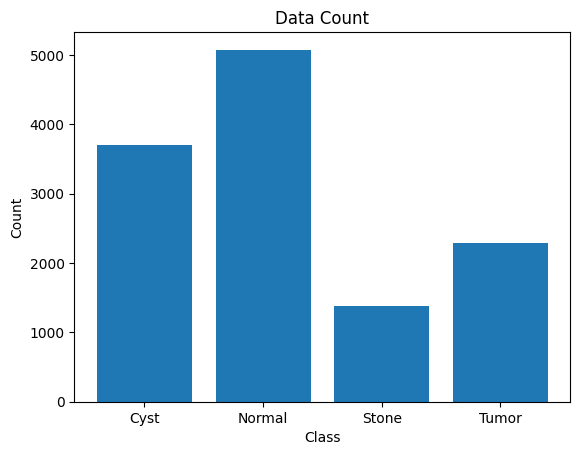

In [ ]:
# Plot the data distribution
plt.bar(count_image["Class"], count_image["Count"])
plt.title("Data Count")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
# Function to get the image sizes and check for consistency
def get_image_size(path, is_pred=False):
    size = []

    # Adjust folders based on prediction mode
    if is_pred:
        folders = [""]
    else:
        folders = os.listdir(path)

    for folder in tqdm(folders):
        folder_path = os.path.join(path, folder)  # Properly construct the folder path
        if os.path.isdir(folder_path):  # Ensure the folder is a directory
            for img in gb.glob(os.path.join(folder_path, "*.jpg")):  # Correct file matching
                image = plt.imread(img)
                size.append(image.shape)  # Get the image shape
    return pd.Series(size).value_counts()

# Analyze image sizes
image_sizes = get_image_size(Images_Path)
image_sizes



  0%|          | 0/4 [00:00<?, ?it/s]

,count
"(512, 512, 3)",7709
"(646, 798, 3)",240
"(651, 804, 3)",179
"(622, 768, 3)",177
"(680, 840, 3)",171
...,...
"(611, 754, 3)",6
"(476, 588, 3)",6
"(591, 731, 3)",5
"(647, 801, 3)",4


# Make Transformations Based on Analysis

In [ ]:
# Apply transformations to the images
input_size = 224
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),  # Resize images
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.RandomRotation(10),   # Apply random rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),   # Adjust color
    transforms.ToTensor(),   # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # Normalize
])

test_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split Dataset
   - Split into Training, Validation, and Test sets
   - Prepare DataLoaders

In [ ]:
# Split dataset into training, validation, and test sets
dataset = datasets.ImageFolder(Images_Path, transform=train_transforms)

In [ ]:
# Define ratios for splitting
batch_size = 32
train_ratio = 0.85
val_ratio = 0.10
test_ratio = 0.05

# Calculate sizes for splits
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Display dataset details
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 10579
Validation set size: 1244
Test set size: 623


In [ ]:
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

In [ ]:
class_names = dataset.classes
print(class_names)

['Cyst', 'Normal', 'Stone', 'Tumor']


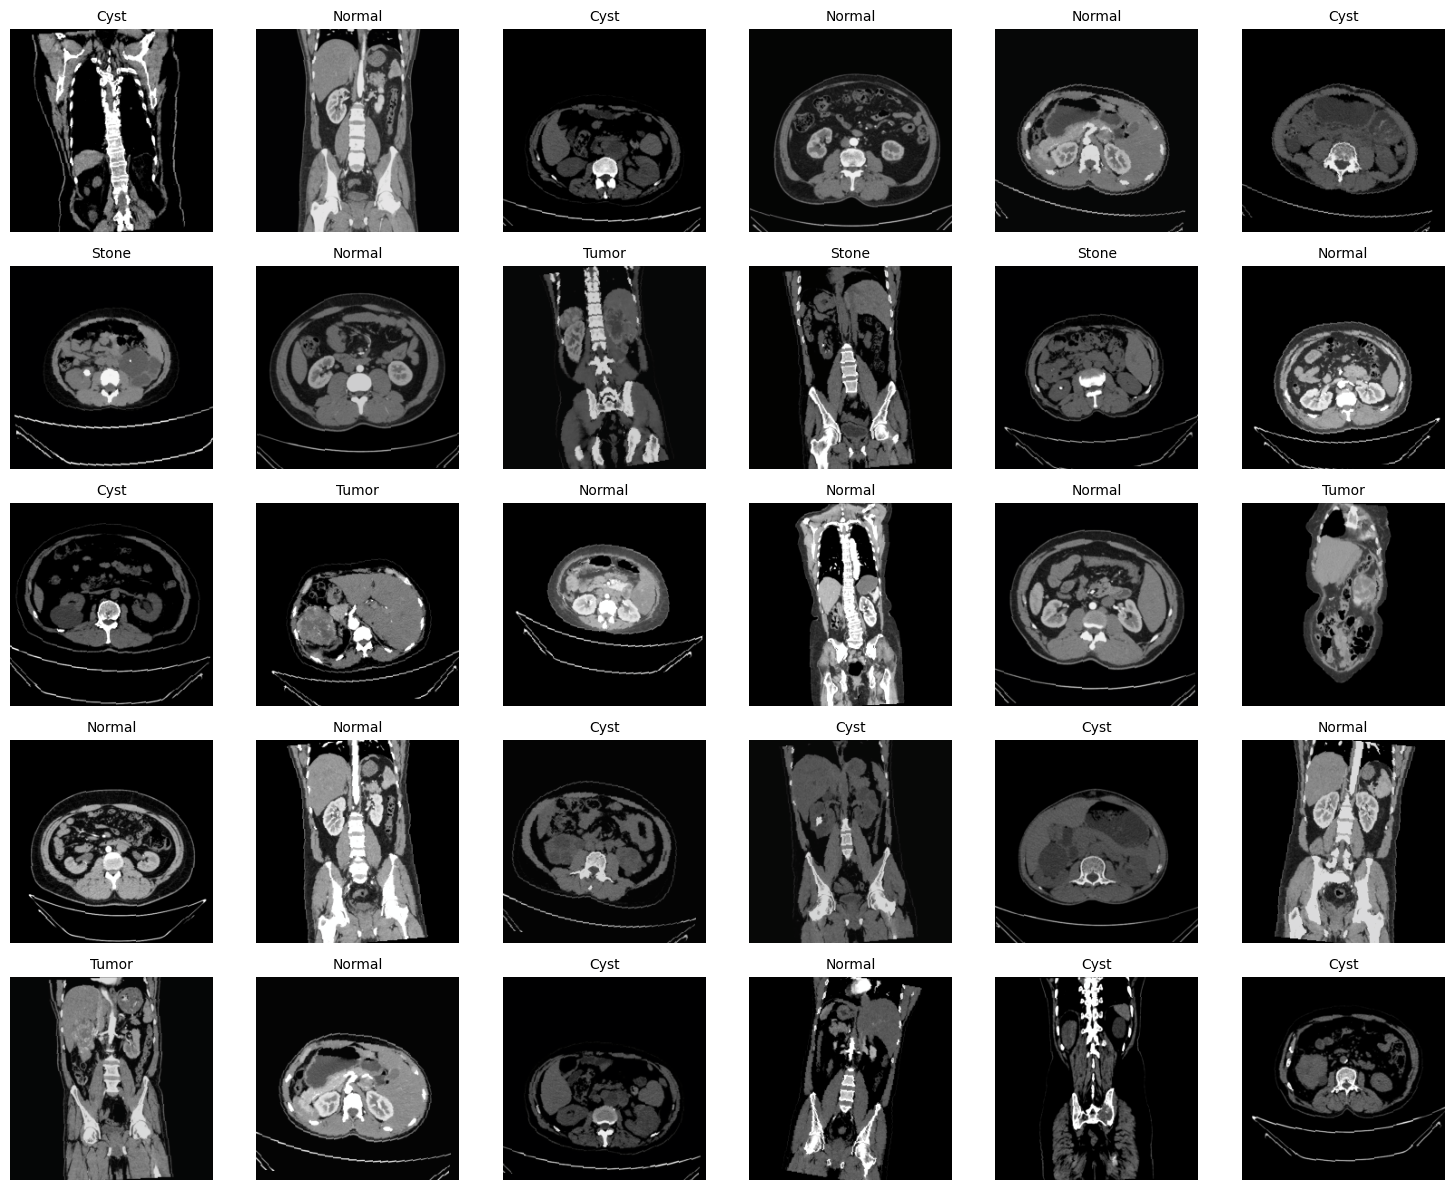

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

# Display images with titles below each image (fixed size: 5x6 grid)
def imshow_fixed_grid(images, labels, nrow=6, nrows=5):
    # Convert tensor to numpy and undo normalization
    images = images.numpy().transpose((0, 2, 3, 1))  # Rearrange dimensions
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean  # Undo normalization
    images = np.clip(images, 0, 1)  # Clip values to [0, 1]

    # Ensure only 30 images (5x6 grid)
    max_images = nrow * nrows
    images = images[:max_images]
    labels = labels[:max_images]

    fig, axes = plt.subplots(nrows, nrow, figsize=(15, 12))  # Adjust figure size
    axes = axes.flatten()  # Flatten to make indexing easier

    # Loop through each image and add it to the grid
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(labels[i], fontsize=10)  # Add label below each image
        ax.axis('off')  # Remove axes

    plt.tight_layout()
    plt.show()

# Get inputs and classes from the dataloader
inputs, classes = next(iter(dataloaders['train']))

# Map class indices to their names
labels = [class_names[x] for x in classes]

# Display a 5x6 grid
imshow_fixed_grid(inputs, labels, nrow=6, nrows=5)

# Build Model Architecture
   - Show the summary of the model
   - Define loss function

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import numpy as np
from PIL import Image
from tempfile import TemporaryDirectory
import torch.backends.cudnn as cudnn

# Enable benchmarking for better performance
cudnn.benchmark = True

# Display plots inline
plt.ion()

In [ ]:
num_classes = 4
num_epochs = 10
learning_rate = 0.001

In [ ]:
# Load pre-trained EfficientNet
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 72.5MB/s]


In [ ]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
import torch
from torch import nn
from collections import Counter

def calculate_class_weights(dataloader, num_classes, device):
    class_counts = Counter()

    for _, labels in dataloader:
        class_counts.update(labels.cpu().numpy())

    total_samples = sum(class_counts.values())
    weights = [1.0 / class_counts[i] if i in class_counts else 0 for i in range(num_classes)]
    weights = torch.tensor(weights, dtype=torch.float, device=device)

    return weights


weights = calculate_class_weights(train_loader, num_classes, device)
print(weights)

criterion = nn.CrossEntropyLoss(weight=weights)


tensor([0.0003, 0.0002, 0.0009, 0.0005], device='cuda:0')


In [ ]:
# optimizer, and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

# Training Loop
   - Train on Training data
   - Show and evaluate on Validation data

In [ ]:
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
from tabulate import tabulate
import torch

# Training function with all metrics printed per epoch
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, device):
    best_val_acc = 0.0
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        # Training phase
        model.train()   # Set model to training mode
        train_loss, train_correct = 0.0, 0
        total_train = 0
        y_true_train, y_pred_train = [], []

        train_loader = tqdm(dataloaders['train'], desc=f"Training Epoch {epoch+1}", leave=False)
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()   # Clear gradients from previous step
            outputs = model(inputs)    # Forward pass
            loss = criterion(outputs, labels)    # Compute loss
            loss.backward()    # Backward pass
            optimizer.step()    # Update model parameters

            train_loss += loss.item() * inputs.size(0)    # Accumulate loss
            _, preds = torch.max(outputs, 1)    # Get the predicted class
            train_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

            train_loader.set_postfix(loss=f"{loss.item():.4f}")

        scheduler.step()
        train_acc = train_correct / total_train
        train_loss = train_loss / total_train

        # Training metrics
        train_precision = precision_score(y_true_train, y_pred_train, average='macro')
        train_recall = recall_score(y_true_train, y_pred_train, average='macro')
        train_f1 = f1_score(y_true_train, y_pred_train, average='macro')

        # Validation phase
        model.eval()    # Set model to evaluation mode
        val_loss, val_correct = 0.0, 0
        total_val = 0
        y_true_val, y_pred_val = [], []

        val_loader = tqdm(dataloaders['val'], desc=f"Validation Epoch {epoch+1}", leave=False)
        with torch.no_grad():   # Disable gradient calculation for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                total_val += labels.size(0)

                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(preds.cpu().numpy())

                val_loader.set_postfix(loss=f"{loss.item():.4f}")

        val_acc = val_correct / total_val
        val_loss = val_loss / total_val

        # Validation metrics
        val_precision = precision_score(y_true_val, y_pred_val, average='macro')
        val_recall = recall_score(y_true_val, y_pred_val, average='macro')
        val_f1 = f1_score(y_true_val, y_pred_val, average='macro')

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'Kidney_Diseases_Classfication_Model.pth')

        # Update history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Print metrics for the epoch
        print("\nMetrics for Epoch:")
        headers = ["Metric", "Train", "Validation"]
        rows = [
            ["Loss", f"{train_loss:.4f}", f"{val_loss:.4f}"],
            ["Accuracy", f"{train_acc:.4f}", f"{val_acc:.4f}"],
            ["Precision", f"{train_precision:.4f}", f"{val_precision:.4f}"],
            ["Recall", f"{train_recall:.4f}", f"{val_recall:.4f}"],
            ["F1-Score", f"{train_f1:.4f}", f"{val_f1:.4f}"],
        ]
        print(tabulate(rows, headers=headers, tablefmt="fancy_grid"))

    print("\nTraining complete.")
    return history


In [ ]:
# Train the model
history= train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, device)


Epoch 1/10
----------------------------------------



Metrics for Epoch:
╒═══════════╤═════════╤══════════════╕
│ Metric    │   Train │   Validation │
╞═══════════╪═════════╪══════════════╡
│ Loss      │  0.2203 │       0.0627 │
├───────────┼─────────┼──────────────┤
│ Accuracy  │  0.9237 │       0.9759 │
├───────────┼─────────┼──────────────┤
│ Precision │  0.8951 │       0.9718 │
├───────────┼─────────┼──────────────┤
│ Recall    │  0.921  │       0.9791 │
├───────────┼─────────┼──────────────┤
│ F1-Score  │  0.9064 │       0.9751 │
╘═══════════╧═════════╧══════════════╛

Epoch 2/10
----------------------------------------



Metrics for Epoch:
╒═══════════╤═════════╤══════════════╕
│ Metric    │   Train │   Validation │
╞═══════════╪═════════╪══════════════╡
│ Loss      │  0.0702 │       0.0142 │
├───────────┼─────────┼──────────────┤
│ Accuracy  │  0.9767 │       0.9968 │
├───────────┼─────────┼──────────────┤
│ Precision │  0.9662 │       0.9974 │
├───────────┼─────────┼──────────────┤
│ Recall    │  0.9755 │       0.9936 │
├───────────┼─────────┼──────────────┤
│ F1-Score  │  0.9707 │       0.9955 │
╘═══════════╧═════════╧══════════════╛

Epoch 3/10
----------------------------------------



Metrics for Epoch:
╒═══════════╤═════════╤══════════════╕
│ Metric    │   Train │   Validation │
╞═══════════╪═════════╪══════════════╡
│ Loss      │  0.0414 │       0.0771 │
├───────────┼─────────┼──────────────┤
│ Accuracy  │  0.9885 │       0.9695 │
├───────────┼─────────┼──────────────┤
│ Precision │  0.9829 │       0.9659 │
├───────────┼─────────┼──────────────┤
│ Recall    │  0.987  │       0.9755 │
├───────────┼─────────┼──────────────┤
│ F1-Score  │  0.9849 │       0.9694 │
╘═══════════╧═════════╧══════════════╛

Epoch 4/10
----------------------------------------



Metrics for Epoch:
╒═══════════╤═════════╤══════════════╕
│ Metric    │   Train │   Validation │
╞═══════════╪═════════╪══════════════╡
│ Loss      │  0.0337 │       0.009  │
├───────────┼─────────┼──────────────┤
│ Accuracy  │  0.9905 │       0.9968 │
├───────────┼─────────┼──────────────┤
│ Precision │  0.9866 │       0.9958 │
├───────────┼─────────┼──────────────┤
│ Recall    │  0.99   │       0.9965 │
├───────────┼─────────┼──────────────┤
│ F1-Score  │  0.9883 │       0.9962 │
╘═══════════╧═════════╧══════════════╛

Epoch 5/10
----------------------------------------



Metrics for Epoch:
╒═══════════╤═════════╤══════════════╕
│ Metric    │   Train │   Validation │
╞═══════════╪═════════╪══════════════╡
│ Loss      │  0.0427 │       0.0153 │
├───────────┼─────────┼──────────────┤
│ Accuracy  │  0.9888 │       0.996  │
├───────────┼─────────┼──────────────┤
│ Precision │  0.9839 │       0.9971 │
├───────────┼─────────┼──────────────┤
│ Recall    │  0.9875 │       0.9934 │
├───────────┼─────────┼──────────────┤
│ F1-Score  │  0.9857 │       0.9952 │
╘═══════════╧═════════╧══════════════╛

Epoch 6/10
----------------------------------------



Metrics for Epoch:
╒═══════════╤═════════╤══════════════╕
│ Metric    │   Train │   Validation │
╞═══════════╪═════════╪══════════════╡
│ Loss      │  0.0111 │        0.001 │
├───────────┼─────────┼──────────────┤
│ Accuracy  │  0.9974 │        1     │
├───────────┼─────────┼──────────────┤
│ Precision │  0.9966 │        1     │
├───────────┼─────────┼──────────────┤
│ Recall    │  0.9967 │        1     │
├───────────┼─────────┼──────────────┤
│ F1-Score  │  0.9966 │        1     │
╘═══════════╧═════════╧══════════════╛

Epoch 7/10
----------------------------------------



Metrics for Epoch:
╒═══════════╤═════════╤══════════════╕
│ Metric    │   Train │   Validation │
╞═══════════╪═════════╪══════════════╡
│ Loss      │  0.0027 │       0.0004 │
├───────────┼─────────┼──────────────┤
│ Accuracy  │  0.9996 │       1      │
├───────────┼─────────┼──────────────┤
│ Precision │  0.9997 │       1      │
├───────────┼─────────┼──────────────┤
│ Recall    │  0.9996 │       1      │
├───────────┼─────────┼──────────────┤
│ F1-Score  │  0.9996 │       1      │
╘═══════════╧═════════╧══════════════╛

Epoch 8/10
----------------------------------------



Metrics for Epoch:
╒═══════════╤═════════╤══════════════╕
│ Metric    │   Train │   Validation │
╞═══════════╪═════════╪══════════════╡
│ Loss      │  0.005  │       0.0002 │
├───────────┼─────────┼──────────────┤
│ Accuracy  │  0.9988 │       1      │
├───────────┼─────────┼──────────────┤
│ Precision │  0.9983 │       1      │
├───────────┼─────────┼──────────────┤
│ Recall    │  0.9986 │       1      │
├───────────┼─────────┼──────────────┤
│ F1-Score  │  0.9985 │       1      │
╘═══════════╧═════════╧══════════════╛

Epoch 9/10
----------------------------------------



Metrics for Epoch:
╒═══════════╤═════════╤══════════════╕
│ Metric    │   Train │   Validation │
╞═══════════╪═════════╪══════════════╡
│ Loss      │  0.0027 │        0.001 │
├───────────┼─────────┼──────────────┤
│ Accuracy  │  0.9996 │        1     │
├───────────┼─────────┼──────────────┤
│ Precision │  0.9997 │        1     │
├───────────┼─────────┼──────────────┤
│ Recall    │  0.9994 │        1     │
├───────────┼─────────┼──────────────┤
│ F1-Score  │  0.9995 │        1     │
╘═══════════╧═════════╧══════════════╛

Epoch 10/10
----------------------------------------



Metrics for Epoch:
╒═══════════╤═════════╤══════════════╕
│ Metric    │   Train │   Validation │
╞═══════════╪═════════╪══════════════╡
│ Loss      │  0.0028 │       0.0004 │
├───────────┼─────────┼──────────────┤
│ Accuracy  │  0.9991 │       1      │
├───────────┼─────────┼──────────────┤
│ Precision │  0.9984 │       1      │
├───────────┼─────────┼──────────────┤
│ Recall    │  0.9991 │       1      │
├───────────┼─────────┼──────────────┤
│ F1-Score  │  0.9987 │       1      │
╘═══════════╧═════════╧══════════════╛

Training complete.


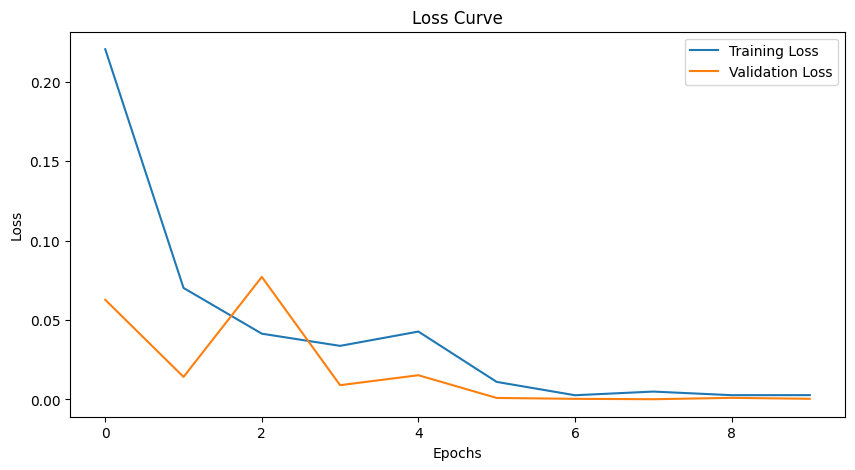

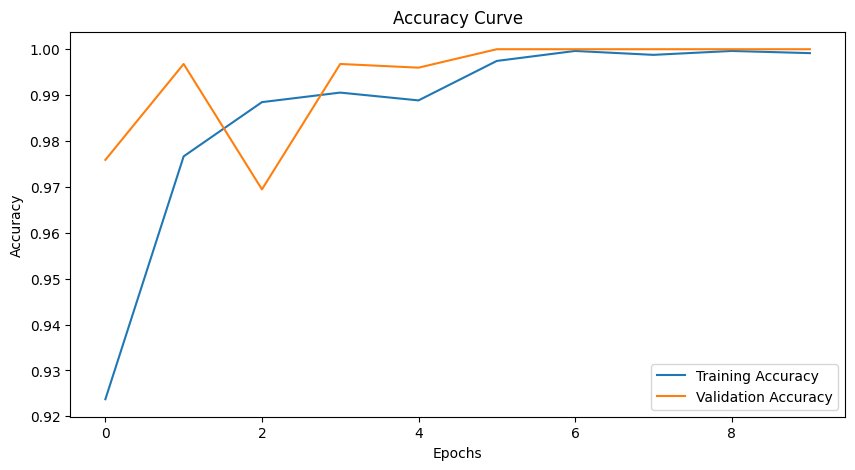

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Evaluate on Test Data
   - Use evaluation metrics:
     - Accuracy
     - F1-Score
     - Recall
     - Precision
     - Confusion Matrix

In [ ]:
# Testing function (modified)
def test_model(model, test_loader, loss1, device):
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    y_true_test, y_pred_test = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss1(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

            y_true_test.extend(labels.cpu().numpy())
            y_pred_test.extend(preds.cpu().numpy())

    # Calculate the metrics
    accuracy = correct_test / total_test
    precision = precision_score(y_true_test, y_pred_test, average='macro')
    recall = recall_score(y_true_test, y_pred_test, average='macro')
    f1 = f1_score(y_true_test, y_pred_test, average='macro')

    # Print metrics
    headers = ["Metric", "Test"]
    rows = [
        ["Loss", f"{test_loss / len(test_loader):.4f}"],
        ["Accuracy", f"{accuracy:.4f}"],
        ["Precision", f"{precision:.4f}"],
        ["Recall", f"{recall:.4f}"],
        ["F1-Score", f"{f1:.4f}"]
    ]
    print(tabulate(rows, headers=headers, tablefmt="fancy_grid"))

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true_test, y_pred_test, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

╒═══════════╤════════╕
│ Metric    │   Test │
╞═══════════╪════════╡
│ Loss      │ 0.0026 │
├───────────┼────────┤
│ Accuracy  │ 1      │
├───────────┼────────┤
│ Precision │ 1      │
├───────────┼────────┤
│ Recall    │ 1      │
├───────────┼────────┤
│ F1-Score  │ 1      │
╘═══════════╧════════╛

Classification Report:
              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       165
      Normal       1.00      1.00      1.00       260
       Stone       1.00      1.00      1.00        66
       Tumor       1.00      1.00      1.00       132

    accuracy                           1.00       623
   macro avg       1.00      1.00      1.00       623
weighted avg       1.00      1.00      1.00       623



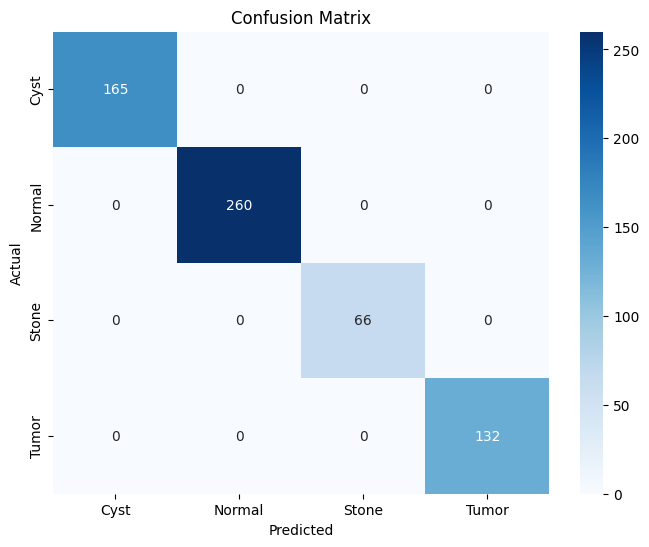

In [ ]:
test_model(model, dataloaders['test'], criterion, device)

In [ ]:
def plot_predictions(model, data, class_names=class_names, device=device):
  plt.figure(figsize=(16, 9))
  rows, cols = 4, 9

  for i in range(1, rows * cols + 1):
    plt.subplot(rows, cols, i)

    random_idx = int(torch.randint(0, len(data), size=[1]).item())
    image, label = data[random_idx]

    model.eval()
    with torch.inference_mode():
      pred_label = model(image.unsqueeze(0).to(device)).argmax(dim=1)


    # Convert tensor to numpy array and adjust channel order
    npimg = image.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))  # Change (C, H, W) to (H, W, C)

    # Reverse normalization to restore original color range
    npimg = npimg * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    npimg = np.clip(npimg, 0, 1)  # Clip values to valid range [0, 1]
    plt.imshow(npimg)
    plt.axis('off')


    title_text = f"Pred: {class_names[pred_label]} \nTrue: {class_names[label]}".title()
    if pred_label == label:
      plt.title(title_text, fontsize=10, c="g")
    else:
      plt.title(title_text, fontsize=10, c="r")

  plt.tight_layout()
  plt.show()

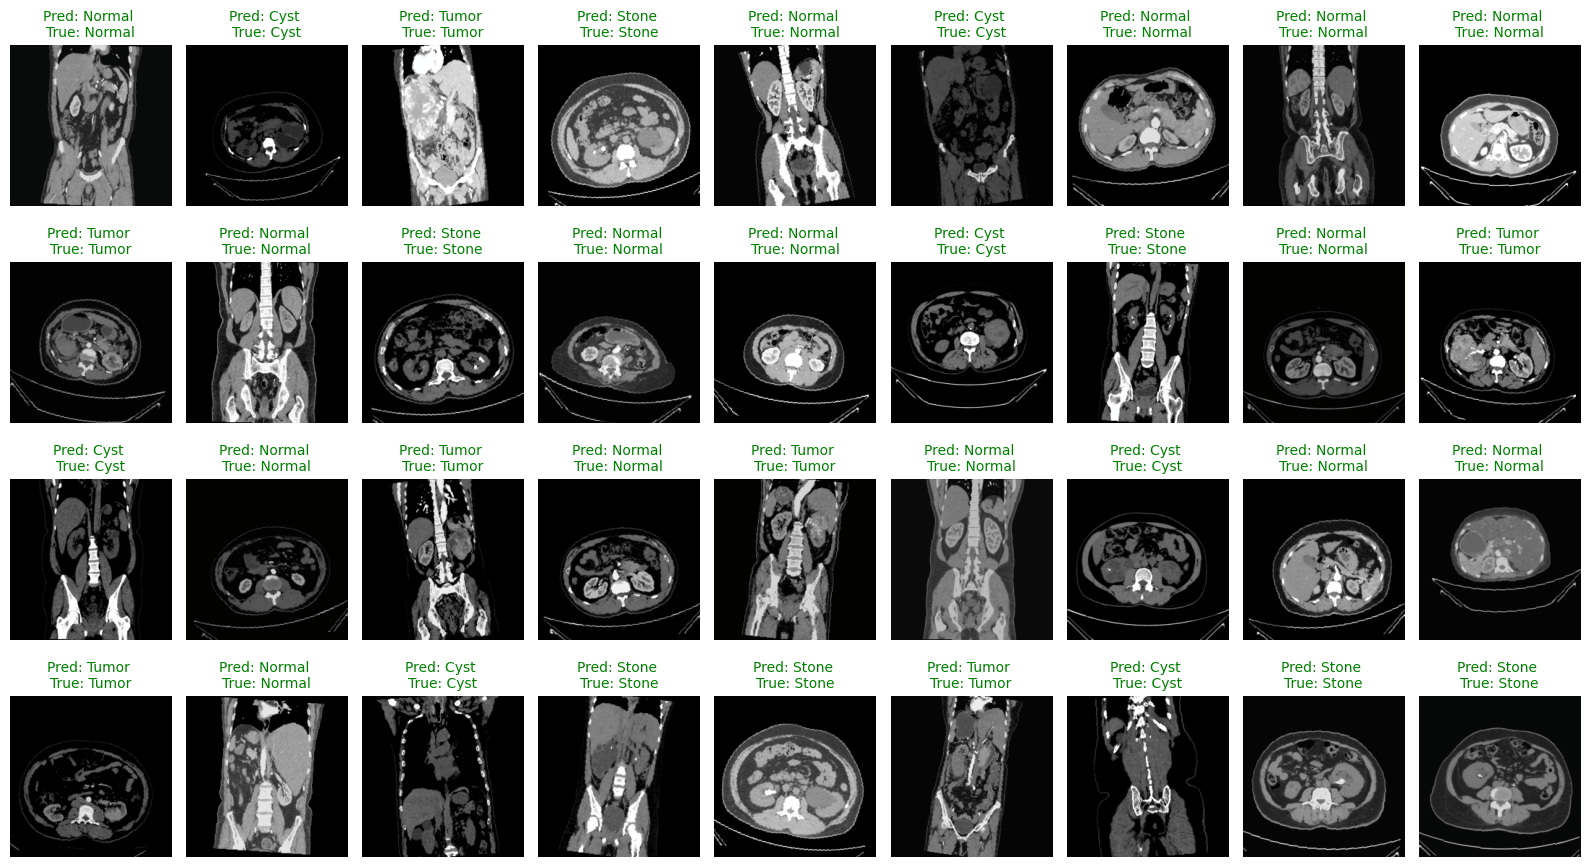

In [ ]:
plot_predictions(data= test_dataset, model= model)

# Make Predictions
   - Visualize results
   - Save the model

In [ ]:
def imshow_fixed_grid1(img, labels):
    """
    Displays an image with fixed grid size.

    Args:
        img (torch.Tensor): The input image tensor.
        labels (str): The label corresponding to the input image.
    """
    # Convert tensor to numpy array and adjust channel order
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))  # Change (C, H, W) to (H, W, C)

    # Reverse normalization to restore original color range
    npimg = npimg * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    npimg = np.clip(npimg, 0, 1)  # Clip values to valid range [0, 1]

    plt.imshow(npimg)
    plt.title(labels)
    plt.axis('off')
    plt.show()

In [ ]:
def visualize_model_predictions(model, img_path):
    """
    Visualizes the prediction of a model for a single input image.

    Args:
        model (torch.nn.Module): The trained model to use for prediction.
        img_path (str): Path to the input image file.
    """
    was_training = model.training
    model.eval()
    img = Image.open(img_path)

    # Assuming train_transforms is a torchvision.transforms.Compose instance:
    # We'll re-create the validation transforms here
    from torchvision import transforms  # Import transforms if not already imported
    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),  # Example resize (adjust if needed)
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example normalization
    ])

    img = val_transforms(img)  # Apply validation transforms

    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2, 2, 1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')

        # Pass the predicted label to imshow_fixed_grid1
        imshow_fixed_grid1(img.cpu().data[0], class_names[preds[0]])

    model.train(mode=was_training)

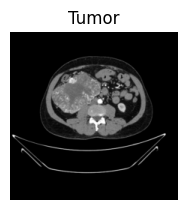

In [ ]:
visualize_model_predictions(
    model,
    img_path= "/content/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (100).jpg"
)

plt.ioff()
plt.show()